## Collatz beta notebook

In [635]:
"""
This notebook analyses the betas of collatz sequences and their relationship
to other components. The beta  of an odd collatz number is defined by the 
following equation: beta = 1 + 1/k*x where x is the odd number. 
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
import random as rnd
import matplotlib.pyplot as plt
from math import log2
import pandas as pd
from collatz import commons as com
from collatz import generator as gen


# Configuration
k = 3
max_value = 1001
max_iterations = 300
start_value = rnd.randint(1, max_value)

if start_value % 2 == 0:
    start_value = start_value + 1

# start_value = 27

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Create a collatz sequence and analyse it
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=start_value, k=k, max_iterations=max_iterations)

# Drop last row if sequences has ended with 1
if len(analysis_frame) > 1:
    analysis_frame = analysis_frame[:-1]

# Derive additional fields
analysis_frame["n"] = analysis_frame.index + 1
analysis_frame["v1"] = start_value

# Calculate alpha
analysis_frame["alpha"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha"] = analysis_frame["alpha"].astype("int64")
analysis_frame["alpha_sum"] = analysis_frame["alpha"].cumsum()
analysis_frame["alpha_max"] = analysis_frame["n"] * log2(k) + log2(start_value)
analysis_frame["alpha_max"] = analysis_frame["alpha_max"].astype('int64') + 1

# Calculate beta
analysis_frame["beta_i"] = 1 + 1/(k*analysis_frame["collatz"])
analysis_frame["beta"] = analysis_frame["beta_i"].cumprod()
analysis_frame["beta_log"] = analysis_frame["beta"].apply(log2)
analysis_frame["beta_log_hyp"] = analysis_frame["alpha_max"] - \
                             analysis_frame["n"] * log2(k) - log2(start_value)

analysis_frame["beta_log_cycle"] = (analysis_frame["n"] * log2(k)).astype('int64') + 1 - \
                                   analysis_frame["n"] * log2(k)

analysis_frame["beta_hyp"] = 2**analysis_frame["beta_log_hyp"]

analysis_frame["beta_log_diff"] = \
    (analysis_frame["beta_log_hyp"] - analysis_frame["beta_log"]).round(5)

# Print results
print_frame = analysis_frame[[
    "n", "collatz","next_odd",  "alpha_sum", 
    "beta", "beta_hyp", "beta_log", "beta_log_hyp", "beta_log_cycle"]]

print_frame.columns = ["n","vi", "vi_1", "a",
                       "b", "b_hyp", "b_log", "b_log_hyp", "b_log_cyc"]

print("v1:", start_value, " K:", k, 
      "\n")

print(print_frame.to_string(index=False), "\n")

v1: 861  K: 3 

  n    vi  vi_1   a         b     b_hyp     b_log  b_log_hyp  b_log_cyc
  1   861   323   3  1.000387  1.585753  0.000558   0.665168   0.415037
  2   323   485   4  1.001420  1.057169  0.002047   0.080206   0.830075
  3   485    91   8  1.002108  1.409558  0.003038   0.495243   0.245112
  4    91   137   9  1.005779  1.879411  0.008313   0.910281   0.660150
  5   137   103  11  1.008226  1.252941  0.011819   0.325318   0.075187
  6   103   155  12  1.011489  1.670588  0.016480   0.740356   0.490225
  7   155   233  13  1.013664  1.113725  0.019579   0.155393   0.905262
  8   233   175  15  1.015114  1.484967  0.021642   0.570431   0.320300
  9   175   263  16  1.017047  1.979956  0.024387   0.985468   0.735337
 10   263   395  17  1.018337  1.319970  0.026214   0.400506   0.150375
 11   395   593  18  1.019196  1.759961  0.027431   0.815543   0.565412
 12   593   445  20  1.019769  1.173307  0.028242   0.230581   0.980450
 13   445   167  23  1.020533  1.564409  0.02932

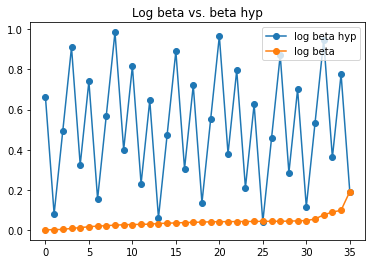

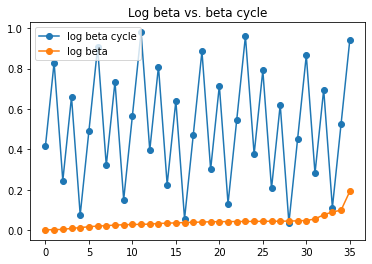

In [636]:
# Plot results
plt.figure()
plt.title("Log beta vs. beta hyp")
plt.plot(analysis_frame["beta_log_hyp"], "-o", label="log beta hyp")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()

plt.figure()
plt.title("Log beta vs. beta cycle")
plt.plot(analysis_frame["beta_log_cycle"], "-o", label="log beta cycle")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()
plt.show()